### development code for tbc et al

In [1]:
# Just your usual setup

import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fft8 as fft8 
import ld_utils as utils

import copy

# for image display
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

In [2]:
pi = np.pi
tau = np.pi * 2

# Make sure this is a power of two!
blocklenk = 2048
blocklen = (blocklenk * 1024)

In [3]:
def dosplot(B, A, freq = (315.0/88.0) * 8.0):
	w, h = sps.freqz(B, A)

	fig = plt.figure()
	plt.title('Digital filter frequency response')

	ax1 = fig.add_subplot(111)

	db = 20 * np.log10(abs(h))

	for i in range(1, len(w)):
		if (db[i] >= -10) and (db[i - 1] < -10):
			print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
		if (db[i] >= -3) and (db[i - 1] < -3):
			print("-3db crossing at ", w[i] * (freq/pi) / 2.0) 
		if (db[i] < -3) and (db[i - 1] >= -3):
			print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 
		if (db[i] < -10) and (db[i - 1] >= -10):
			print("<-10db crossing at ", w[i] * (freq/pi) / 2.0) 
		if (db[i] < -20) and (db[i - 1] >= -20):
			print("<-20db crossing at ", w[i] * (freq/pi) / 2.0) 

	plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
	plt.ylabel('Amplitude [dB]', color='b')
	plt.xlabel('Frequency [rad/sample]')

	plt.show()

def doplot(B, A, freq = (315.0/88.0) * 8.0):
	w, h = sps.freqz(B, A)

	fig = plt.figure()
	plt.title('Digital filter frequency response')
	
	db = 20 * np.log10(abs(h))
	for i in range(1, len(w)):
		if (db[i] >= -10) and (db[i - 1] < -10):
			print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
		if (db[i] >= -3) and (db[i - 1] < -3):
			print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
		if (db[i] < -3) and (db[i - 1] >= -3):
			print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 

	ax1 = fig.add_subplot(111)
	
	plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
	plt.ylabel('Amplitude [dB]', color='b')
	plt.xlabel('Frequency [rad/sample]')

	ax2 = ax1.twinx()
	angles = np.unwrap(np.angle(h))
	plt.plot(w * (freq/pi) / 2.0, angles, 'g')
	plt.ylabel('Angle (radians)', color='g')
	
	plt.grid()
	plt.axis('tight')
	plt.show()

def doplot2(B, A, B2, A2, freq = (315.0/88.0) * 8.0):
	w, h = sps.freqz(B, A)
	w2, h2 = sps.freqz(B2, A2)

#	h.real /= C
#	h2.real /= C2

	begin = 0
	end = len(w)
#	end = int(len(w) * (12 / freq))

#	chop = len(w) / 20
	chop = 0
	w = w[begin:end]
	w2 = w2[begin:end]
	h = h[begin:end]
	h2 = h2[begin:end]

	v = np.empty(len(w))
	
#	print len(w)

	hm = np.absolute(h)
	hm2 = np.absolute(h2)

	v0 = hm[0] / hm2[0]
	for i in range(0, len(w)):
#		print i, freq / 2 * (w[i] / pi), hm[i], hm2[i], hm[i] / hm2[i], (hm[i] / hm2[i]) / v0
		v[i] = (hm[i] / hm2[i]) / v0

	fig = plt.figure()
	plt.title('Digital filter frequency response')

	ax1 = fig.add_subplot(111)

	v  = 20 * np.log10(v )

#	plt.plot(w * (freq/pi) / 2.0, v)
#	plt.show()
#	exit()

	plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'r')
	plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h2)), 'b')
	plt.ylabel('Amplitude [dB]', color='b')
	plt.xlabel('Frequency [rad/sample]')
	
	ax2 = ax1.twinx()
	angles = np.unwrap(np.angle(h))
	angles2 = np.unwrap(np.angle(h2))
	plt.plot(w * (freq/pi) / 2.0, angles, 'g')
	plt.plot(w * (freq/pi) / 2.0, angles2, 'y')
	plt.ylabel('Angle (radians)', color='g')

	plt.grid()
	plt.axis('tight')
	plt.show()

# This matches FDLS-based conversion surprisingly well (i.e. FDLS is more accurate than I thought ;) )
def BA_to_FFT(B, A, blocklen):
    return np.complex64(sps.freqz(B, A, blocklen, whole=True)[1])



# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
#    imshow(np.asarray(im))
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())
                         
#drawdata(data)                         


In [4]:
# System default specs for NTSC and PAL.

NTSC_hz_ire = (9300000 - 7600000) / 140.0 # Later disks may have a higher white point

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,
    'audio_filtwidth': 200000,
    'audio_filtorder': 1,

    'fsc_mhz': (315.0 / 88.0),
    'line_period': 63.5, # in usecs

    # video frequencies 
    # per spec, range from -40 to 100 IRE is 1.7mhz, so 12142 ire/mhz
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match 0-65534 scaling
    'ire_min': -60,
    'ire_max': 140,

    # changeable defaults
    #'deemp': (120, 320), # actual deemp timing
    'deemp': (135, 320),

    'vbpf': (3200000, 14000000),
    'vbpf_order': 1,
    
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 4 # butterworth filter order
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    'line_period': 64, # in usecs
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on LD this includes a very strong pilot signal
    'videorf_0ire': 7100000,
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'analog_audio': False, # not true for later PAL

    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order

    'audio_filtwidth': 200000,
    'audio_filtorder': 1,
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    

In [5]:
# Domesday Duplicator system uses 32mhz/10bit, expressed as 16-bit signed integers
CapParams_DomesdayDuplicator = {
    'freq': 44.0,
    'dtype': np.int16,
}

# cxadc can only really capture at 8fsc (28.8xmhz), with 8-bit unsigned samples
CapParams_cxadc = {
    'freq': (315.0 / 88.0) * 8.00,
    'dtype': np.uint8,
}

try:
    tmp = CapParams['freq']
except:
    CapParams = CapParams_cxadc

In [6]:
# old lddecode format
minire = -60
maxire = 140
hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [7]:
CapParams = CapParams_cxadc
CapParams = CapParams_DomesdayDuplicator
SysParams = copy.deepcopy(SysParams_NTSC)

In [8]:
SysParams['vsync_freq'] = 1000000
SysParams['vsync_order'] = 3

In [9]:
OverrideParams = {}

params = {}

for p in [SysParams, CapParams, OverrideParams]:
    for k in p.keys():
        print(k, p[k])
        params[k] = p[k]

system_name NTSC
audio_lfreq 2301136
audio_rfreq 2812499
analog_audio True
audio_filtwidth 200000
audio_filtorder 1
fsc_mhz 3.5795454545454546
line_period 63.5
hz_ire 12142.857142857143
videorf_sync 8585714.285714285
videorf_0ire 8100000
videorf_7.5ire 8191071.428571428
videorf_100ire 9314285.714285715
ire_min -60
ire_max 140
deemp (135, 320)
vbpf (3200000, 14000000)
vbpf_order 1
vlpf_freq 4200000
vlpf_order 4
vsync_freq 1000000
vsync_order 3
freq 44.0
dtype <class 'numpy.int16'>


In [10]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

In [11]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*200+[0]*200)
    #np.fft.ifft([0]+[1]*(blocklen//4)+[0]*(blocklen//4))
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do the 'heavy lifting'
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

# A rather pants attempt at doing an MTF function. This needs to be better.
[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.0)
Fmtf = filtfft([tf_b, tf_a])

# This prepares the needed transforms to do the actual video decoding
def prepare_video_filters(SP):
    SP['freq_hz'] = SP['freq'] * 1000000
    SP['line_px'] = SP['freq_hz'] * (SP['line_period'] / 1000000)
        
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2

    # RF BPF and analog audio cut filters
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'))
    
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    # standard post-demod LPF
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low'))
    SP['Fvideo_lpf05'] = filtfft(sps.butter(SP['vlpf_order'], 0.5/freq_hz_half, 'low'))

    # post-demod deemphasis filter
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))

    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp']
    SP['FVideo05'] = SP['Fvideo_lpf05'] * SP['Fdeemp']

In [12]:
# The actual video demodulation code
def dodemod(params, data, clip = None, usemtf = False, cutarf = False):
    prepare_video_filters(params)

    data_fft = np.fft.fft(data)
    
    datac = data_fft * params['FRFVideo']
    if usemtf is True:
        datac *= Fmtf
    
    hilbert = np.fft.ifft(datac * fft_hilbert)

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
            dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    demod = (tdangles2 * (params['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)

    # note: imaginary component of this ifft is virtually zero
    output = np.fft.ifft(demod_fft * params['FVideo']).real
    
    return output


In [13]:
def lineplot(output, param):
    plt.plot(output)
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [14]:
prepare_video_filters(params)

/home/cpage/anaconda3/lib/python3.6/site-packages/scipy/signal/filter_design.py:346: RuntimeWarning: divide by zero encountered in true_divide
  h = polyval(b[::-1], zm1) / polyval(a[::-1], zm1)
/home/cpage/anaconda3/lib/python3.6/site-packages/scipy/signal/filter_design.py:346: RuntimeWarning: invalid value encountered in true_divide
  h = polyval(b[::-1], zm1) / polyval(a[::-1], zm1)
/home/cpage/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply


In [15]:
def calcsnr(a):
    stdire = np.std(a) / NTSC_hz_ire
    print(20 * np.log10(100 / stdire))

In [16]:
#infile = open('.raw', 'rb')
infile = open('/home/cpage/erica_44a-54020.raw', 'rb')
#infile.seek(1024 * 1024 * 1024)
inbuf = infile.read(1024 * 1024 * 8)
indata1 = np.fromstring(inbuf, 'int16', len(inbuf) // 2)

data1 = indata1[400000:400000+blocklen]
#data2 = indata1[blocklen:blocklen*2]


In [17]:
blockcut = 1024

SysParams = copy.deepcopy(SysParams_NTSC)
params = {}

In [18]:
for p in [SysParams, CapParams, OverrideParams]:
    for k in p.keys():
        #print(k, p[k])
        params[k] = p[k]

        adj = 1
params['deemp'] = [120*adj, 320*adj]
params['vbpf'] = (3500000, 14000000)
params['vbpf_order'] = 6

params['ahpf_freq'] = 3100000
params['ahpf_order'] = 2

params['vlpf_freq'] = 4200000
params['vlpf_order'] = 5

output1 = dodemod(copy.deepcopy(params), data1, usemtf=False)
#calcsnr(output1[214400:215500]), calcsnr(output1[217000:218000]), calcsnr(output1[213820:213950])
calcsnr(output1[156000:157000]), calcsnr(output1[169100:169500])

16.816572182
18.6908897678


(None, None)

In [19]:
def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

15.5072838699
19.4187071069


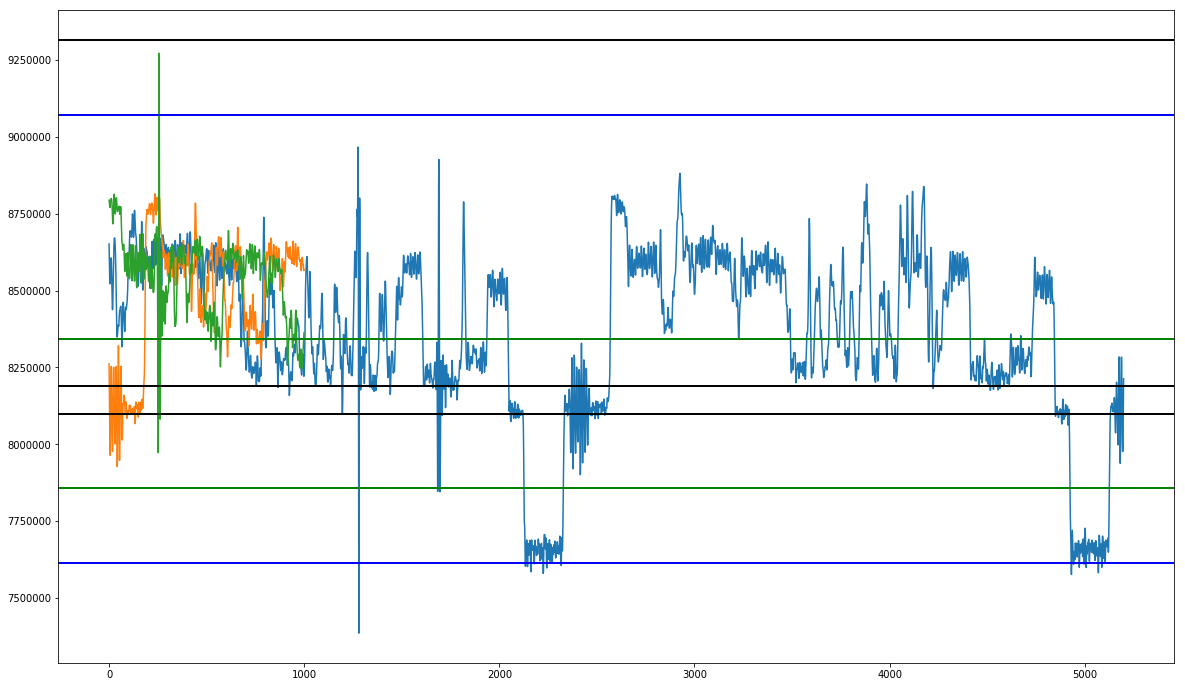

In [20]:
for p in [SysParams, CapParams, OverrideParams]:
    for k in p.keys():
        #print(k, p[k])
        params[k] = p[k]

adj = .6
params['deemp'] = [120*adj, 320*adj]
params['vbpf'] = (3500000, 13200000)
params['vbpf_order'] = 3

params['audio_filtwidth'] = 150000
params['audio_filtorder'] = 1

params['vlpf_freq'] = 4200000
params['vlpf_order'] = 2

output1 = dodemod(copy.deepcopy(params), data1, usemtf=False)

lineplot(output1[219500:224700], params)
lineplot(output1[199500:200500], params)
lineplot(output1[202500:203500], params)
calcsnr(output1[199500:200500])
calcsnr(output1[202500:203500])

In [27]:
# The actual (new?) video demodulation code

#def dodemod(params, data, clip = None, usemtf = False, cutarf = False):
paramsc = copy.deepcopy(params)

ptr = 1024 * 1200
data1 = indata1[ptr:ptr + blocklen]

prepare_video_filters(paramsc)

indata_fft = np.fft.fft(data1)
indata_fft_filt = indata_fft * paramsc['FRFVideo']

indata_fft_filt *= Fmtf


#indata_filt = np.fft.ifft(indata_fft_filt)
hilbert = np.fft.ifft(indata_fft_filt * fft_hilbert)

tangles = np.angle(hilbert)
dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

# make sure unwapping goes the right way
if (dangles[0] < -pi):
    dangles[0] += tau
    
tdangles2 = np.unwrap(dangles) 
tdangles2[tdangles2 < 0] += tau
tdangles2[tdangles2 > tau] -= tau
demod = (tdangles2 * (paramsc['freq_hz'] / tau))

demod_fft = np.fft.fft(demod)
output = np.fft.ifft(demod_fft * paramsc['FVideo']).real

In [28]:
tdangles2

array([ 0.        ,  1.12100706,  1.18635266, ...,  1.1500657 ,
        1.12248184,  1.08380688])

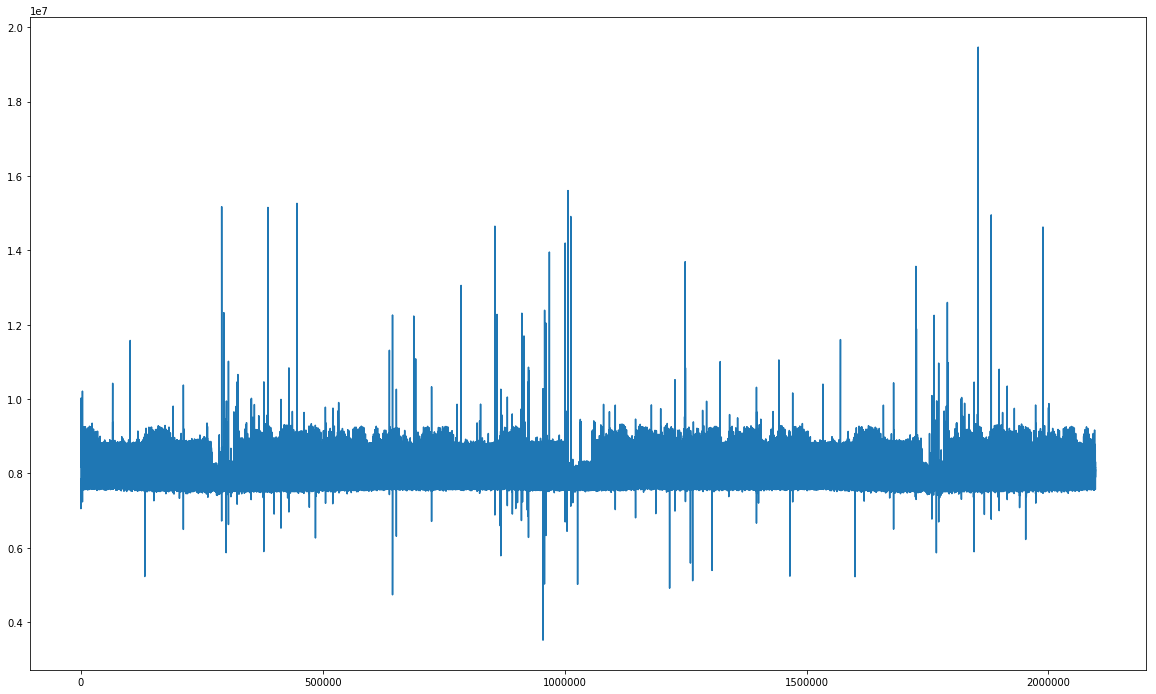

In [29]:
plt.plot(output)

In [30]:
lpf05 = filtfft(sps.butter(4, 0.5/22, 'low'))
output05 = np.fft.ifft(demod_fft * paramsc['Fdeemp'] * lpf05).real

In [31]:
# emperical work determined that a single-pole low frequency filter effectively 
# detects the end of a (regular) sync pulse.  peak levels determine which type 
# of sync pulse.

# A regular pulse should peak around .8, a half pulse around .5-.6, and a vsync pulse ~1 (with fake peaks, bottom ~.2)

f = sps.butter(1, 0.05/(params['freq'] / 2.0), btype='low')
synclpfb = filtfft(f)

In [32]:
output_sync = (output > (params['videorf_0ire'] + (params['hz_ire'] * -50))) & (output < (params['videorf_0ire'] + (params['hz_ire'] * -30)))
output_syncf = np.fft.ifft(np.fft.fft(output_sync) * synclpfb).real

In [33]:
syncs2 = np.diff(output_syncf > .2)
syncs3 = np.diff(output_syncf > .3)

In [34]:
prepare_video_filters(params)

In [35]:
# Build a list of sync pulses.  This method filters out short syncs (filter level 0.35) so it
# produces sensible (if not perfect against rot!) - results

pulses = [(0, -1, -1)]
badpulse = None

for z in zip(np.where(syncs2)[0][1:], np.diff(np.where(syncs2)[0])):
    if (z[0] > z[1]) & (z[1] < (params['line_px'] / 5)):
        if badpulse is not None:
            sync_begin = badpulse
        else:
            sync_begin = z[0]-z[1]
            
        subset = output_syncf[sync_begin:z[0]]
        peakloc = np.argmax(subset) + sync_begin
        linelength = peakloc - pulses[-1][1]
        
        #print(peakloc, output_syncf[peakloc], peakloc - sync_begin)
        
        if output_syncf[peakloc] > .35 and peakloc != pulses[-1][2]:
            #print('p')
            peakloc = np.argmax(subset) + sync_begin
            pulses.append((np.max(subset), peakloc, peakloc - pulses[-1][1], peakloc - sync_begin))
            badpulse = None
        elif badpulse is None:
            badpulse = z[0]
        else: # weak pulse
            gap = peakloc - pulses[-1][1]
            
            if np.abs(gap - params['line_px']) < (params['line_px'] * .01):
                #print('s')
                pulses.append((-np.max(subset), peakloc, peakloc - pulses[-1][1]))
                badpulse = None
                
pulses = pulses[1:]

In [36]:
pulses

[(0.74461209506946524, 2518, 2519, 163),
 (0.75386178250477243, 5315, 2797, 166),
 (0.7541447360818152, 8108, 2793, 166),
 (0.74602254650676492, 10902, 2794, 164),
 (0.75238303680297902, 13698, 2796, 165),
 (0.75112133485477917, 16493, 2795, 167),
 (0.73675721426410434, 19286, 2793, 162),
 (0.75589390141523771, 22083, 2797, 167),
 (0.75763062225786437, 24878, 2795, 168),
 (0.75414473606646903, 27673, 2795, 166),
 (0.73655450122346056, 30466, 2793, 165),
 (0.73539707576284852, 33260, 2794, 163),
 (0.75238303679157603, 36055, 2795, 165),
 (0.74198099689835184, 38848, 2793, 163),
 (0.75238303678299245, 41645, 2797, 165),
 (0.74439842722373362, 44440, 2795, 166),
 (0.75060871398416984, 47233, 2793, 164),
 (0.7501807777595273, 50029, 2796, 164),
 (0.75238303683503438, 52823, 2794, 165),
 (0.74882167706122127, 55617, 2794, 163),
 (0.74882167705349778, 58411, 2794, 163),
 (0.74954059988771826, 61206, 2795, 165),
 (0.74623712872833248, 64002, 2796, 165),
 (0.74882601004323945, 66795, 2793, 163

In [37]:
reduced = (output - minn) / hz_ire_scale
output_u16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

In [61]:
lines = np.zeros((1050 * 2800), dtype=np.uint16)

prevpulse = (-1, -1, -1)
field = -1
newfield = False
l = 0
prevloc = 0
for p in pulses:
    # in case of a malfunction, use the prev line
    if (field > 0) and inrange(p[2], params['line_px'] * 0.9, params['line_px'] * 1.1) and not inrange(p[2], params['line_px'] * 0.99, params['line_px'] * 1.01) and inrange(prevpulse[2], params['line_px'] * 0.98, params['line_px'] * 1.02) and inrange(p[0], .55, .85):
        p = (p[0], prevpulse[1] + prevpulse[2], prevpulse[2], prevpulse[3])
        print("FIX")

    if (field > 0) and inrange(p[2], params['line_px'] * 0.99, params['line_px'] * 1.01) and inrange(p[0], .55, .85):
        newfield = False
        print(l, p)
        newline = output_u16[p[1]:p[1] + int(params['line_px'])]
        if len(newline) == params['line_px']:
            lines[l*int(params['line_px']):(l + 1) * int(params['line_px'])] = newline
        l += 1
        if l >= 1050:
            break
    elif newfield == False and inrange(p[0], .4, .55) and inrange(prevpulse[0], .55, .75):
        if inrange(p[1] - prevpulse[1], params['line_px'] * 0.95, params['line_px'] * 1.05):
            print('field 1', p[1])
            field = 1
            newfield = True
        else:
            print('field 2', p[1])
            field = 2
            newfield = True
    else:
        print('rej', p)
    
    prevpulse = p
            
            

rej (0.74461209506946524, 2518, 2519, 163)
rej (0.75386178250477243, 5315, 2797, 166)
rej (0.7541447360818152, 8108, 2793, 166)
rej (0.74602254650676492, 10902, 2794, 164)
rej (0.75238303680297902, 13698, 2796, 165)
rej (0.75112133485477917, 16493, 2795, 167)
rej (0.73675721426410434, 19286, 2793, 162)
rej (0.75589390141523771, 22083, 2797, 167)
rej (0.75763062225786437, 24878, 2795, 168)
rej (0.75414473606646903, 27673, 2795, 166)
rej (0.73655450122346056, 30466, 2793, 165)
rej (0.73539707576284852, 33260, 2794, 163)
rej (0.75238303679157603, 36055, 2795, 165)
rej (0.74198099689835184, 38848, 2793, 163)
rej (0.75238303678299245, 41645, 2797, 165)
rej (0.74439842722373362, 44440, 2795, 166)
rej (0.75060871398416984, 47233, 2793, 164)
rej (0.7501807777595273, 50029, 2796, 164)
rej (0.75238303683503438, 52823, 2794, 165)
rej (0.74882167706122127, 55617, 2794, 163)
rej (0.74882167705349778, 58411, 2794, 163)
rej (0.74954059988771826, 61206, 2795, 165)
rej (0.74623712872833248, 64002, 2796

In [62]:
(1441398-680346)/2797

272.09581694672863

In [63]:
l*2500

1557500

In [64]:
l

623

(1740662,)
uint8 (623, 2794) (623, 2794)


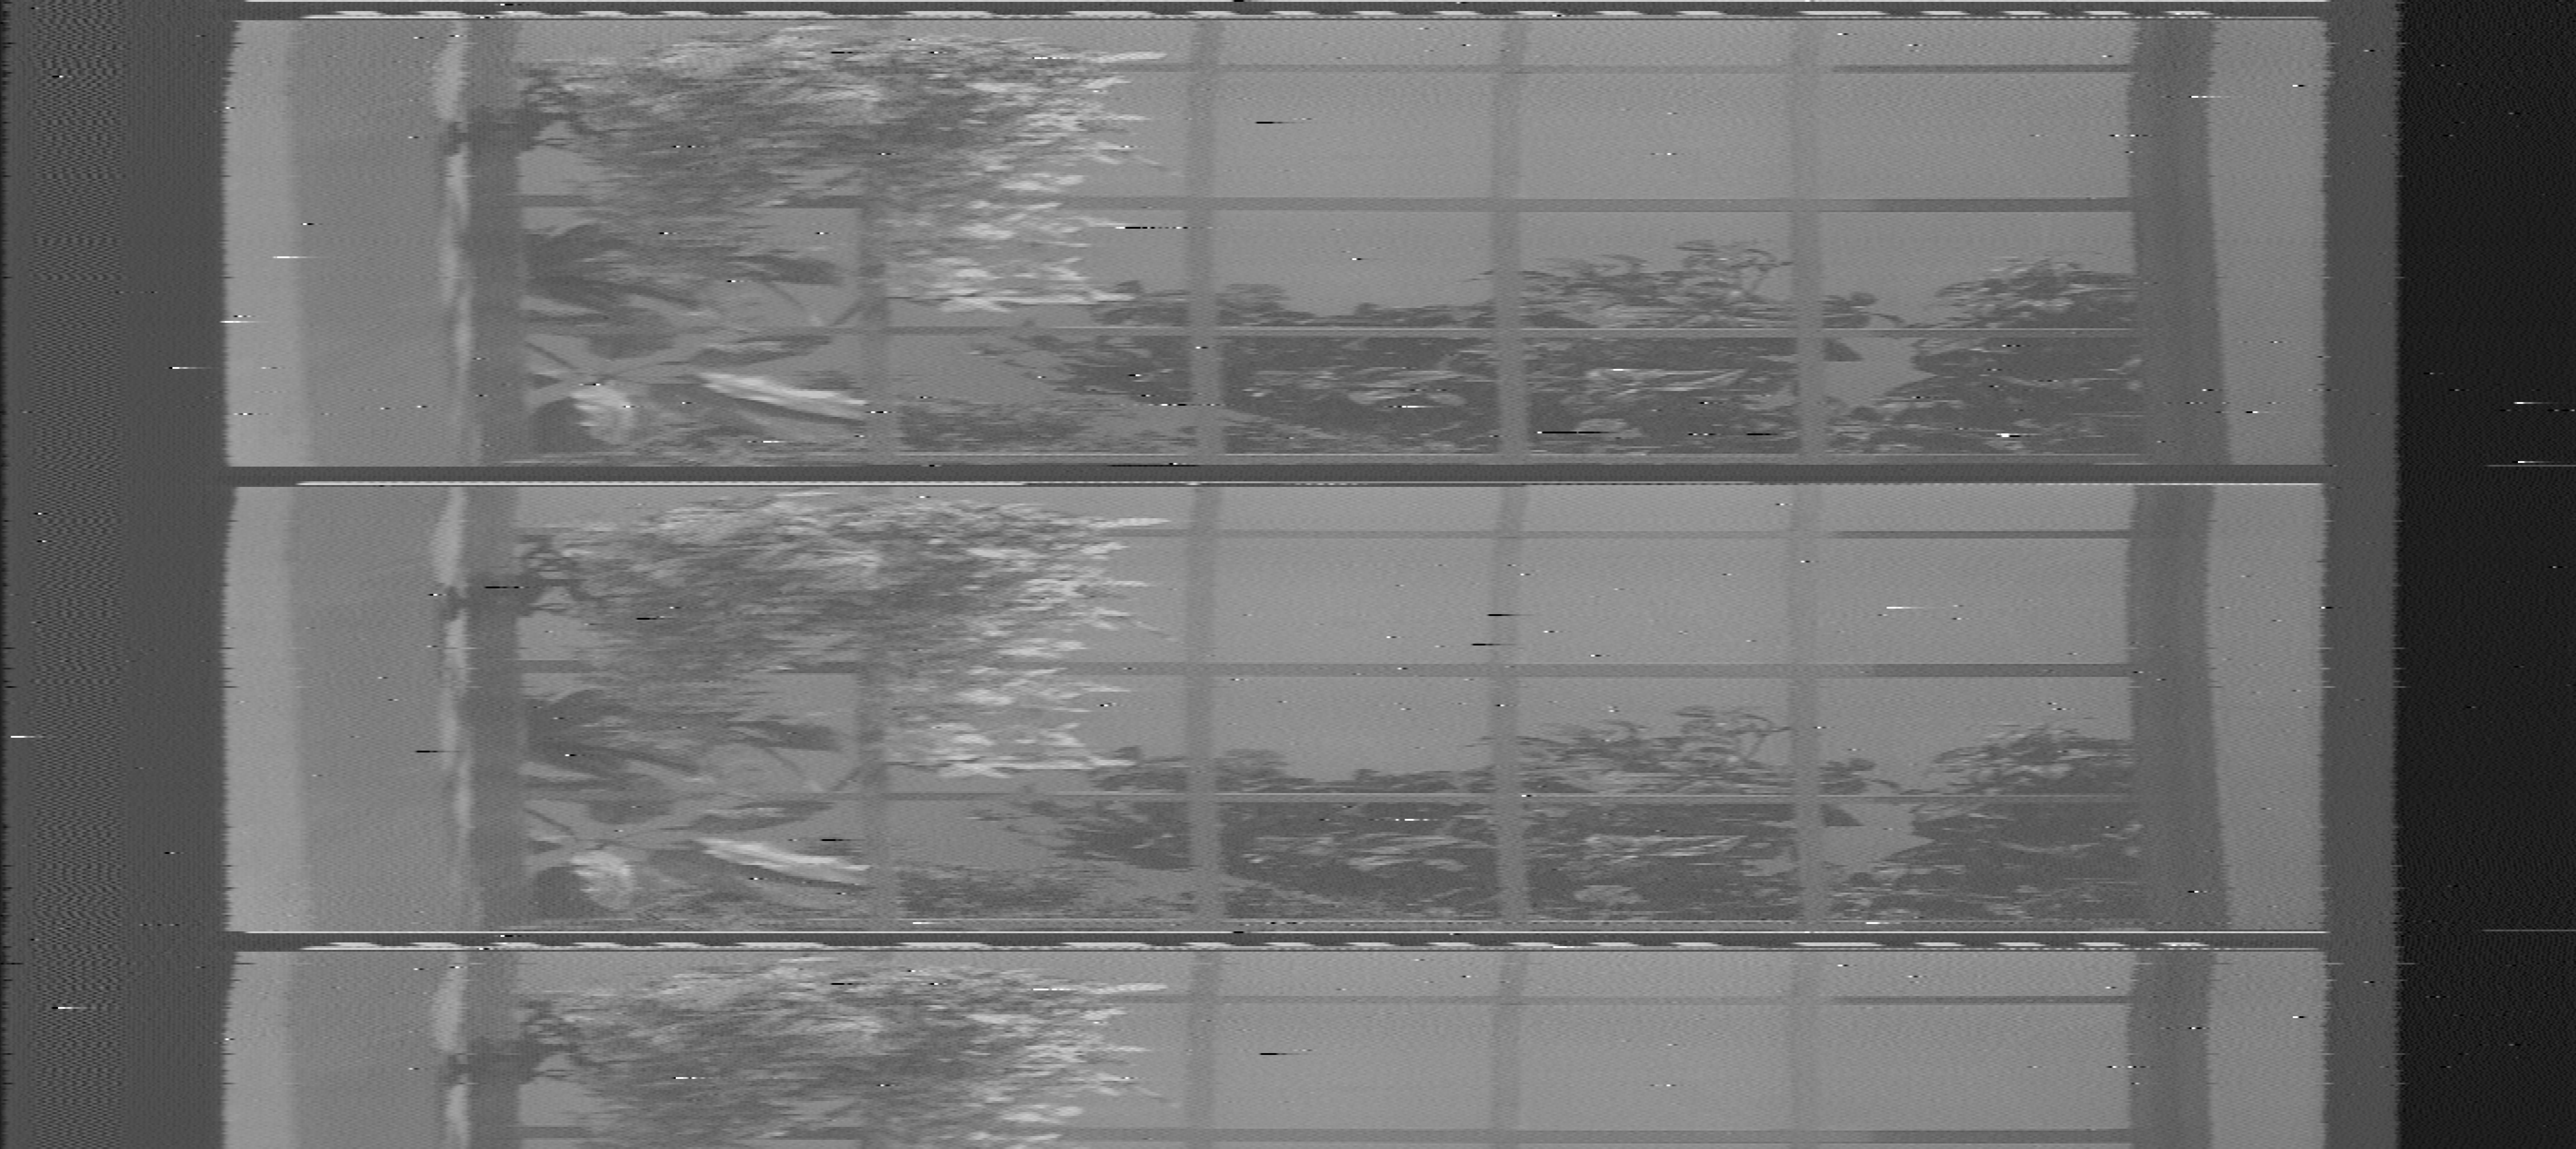

In [65]:
#def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
    
drawdata(lines, int(params['line_px']), l, hscale=2, vscale=4)

In [252]:
syncs1 = np.where((output_syncf[:-1] <= .1) & (output_syncf[1:] > .1))
syncs2 = np.where((output_syncf[:-1] <= .2) & (output_syncf[1:] > .2))

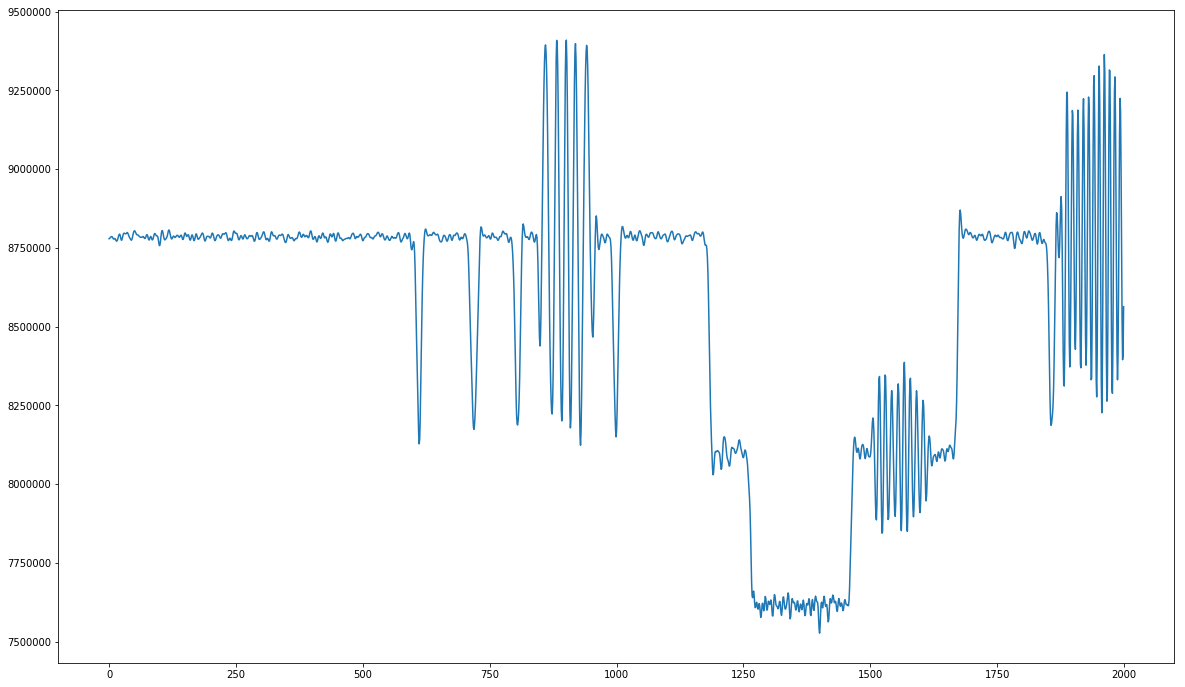

In [253]:
plt.plot(output[37000:39000])

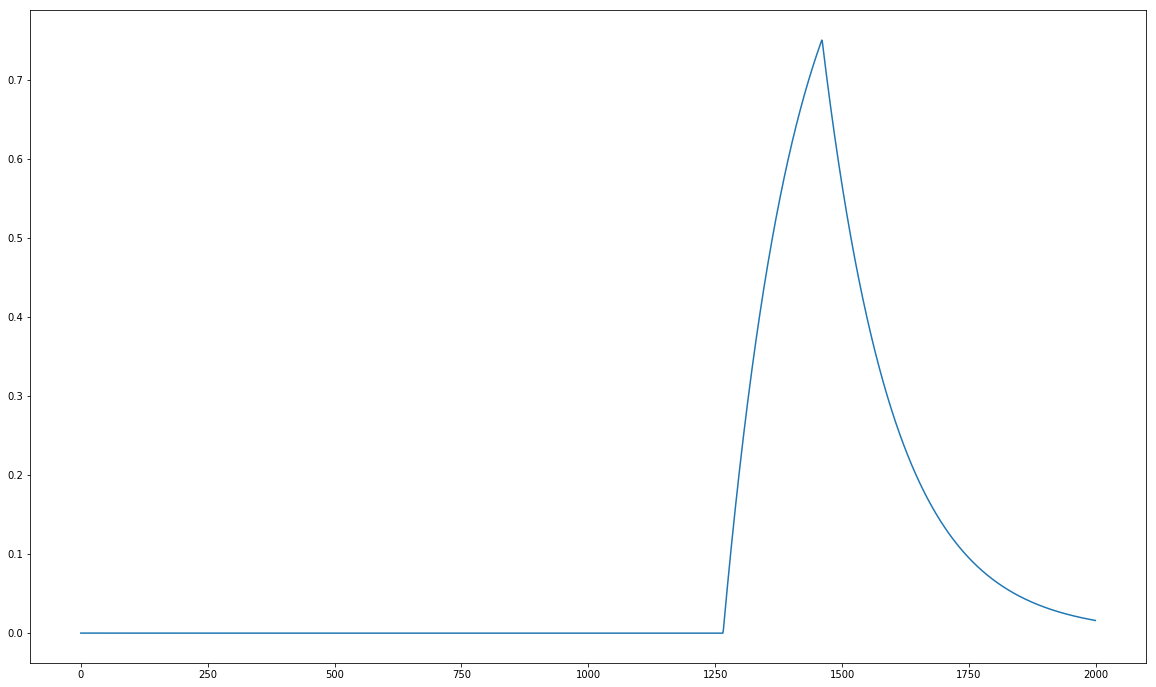

In [254]:
plt.plot(output_syncf[37000:39000])

In [255]:
for s in zip(*syncs1, *np.diff(syncs1)):
    print(s, output[s[0]], output_syncf[s[0]])
    

(1903, 2798) 7615025.36817 0.098345876965
(4701, 2798) 7625210.93761 0.0983458618941
(7499, 2798) 7577088.18994 0.0983458618941
(10297, 2799) 7613658.9314 0.0983458619485
(13096, 2798) 7588338.6712 0.0983458619076
(15894, 2798) 7629458.27709 0.0983458618941
(18692, 2799) 7613908.72228 0.0983458619485
(21491, 2799) 7606023.62841 0.0983458619076
(24290, 2797) 7604075.18018 0.0983458618536
(27087, 2799) 7617429.00822 0.0983458618805
(29886, 2798) 7583745.77191 0.0983458619076
(32684, 2798) 7609258.18656 0.0983458618941
(35482, 2798) 7609227.15617 0.0983458619485
(38280, 2800) 7612905.6398 0.0983458618941
(41080, 2798) 7577397.50643 0.098345861867
(43878, 2798) 7584370.73434 0.0983458618401
(46676, 2797) 7623212.18425 0.0983458618401
(49473, 2799) 7593502.11612 0.0983458619349
(52272, 2798) 7584680.13477 0.0983458619076
(55070, 2798) 7604653.04492 0.0983458618941
(57868, 2797) 7610318.56106 0.0983458618941
(60665, 2799) 7634119.85312 0.0983458619349
(63464, 2797) 7554587.65194 0.0983458619

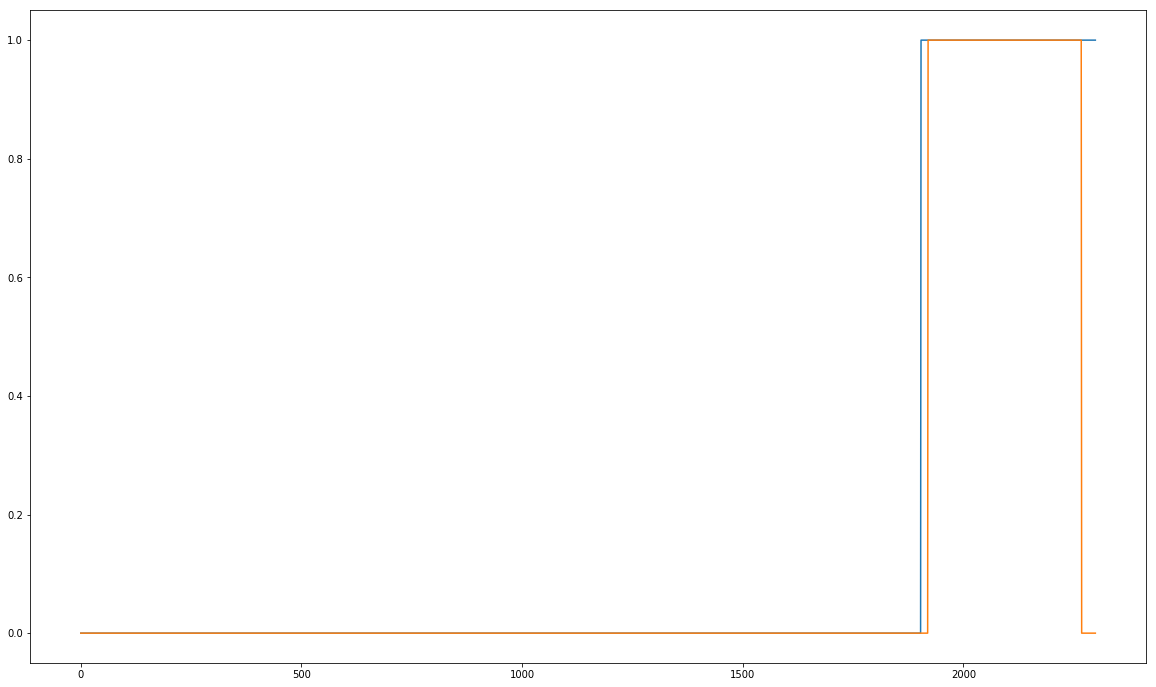

In [256]:
plt.plot(output_syncf[0:2300] > .1)
plt.plot(output_syncf[0:2300] > .2)

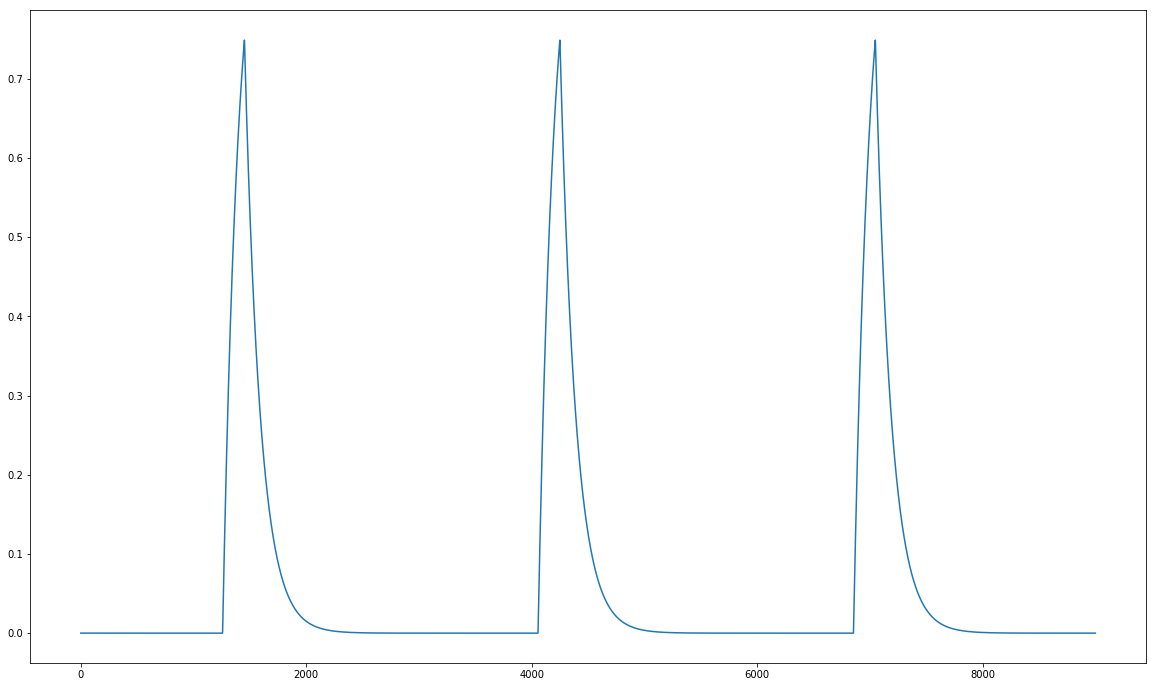

In [257]:
plt.plot(output_syncf[51000:60000])

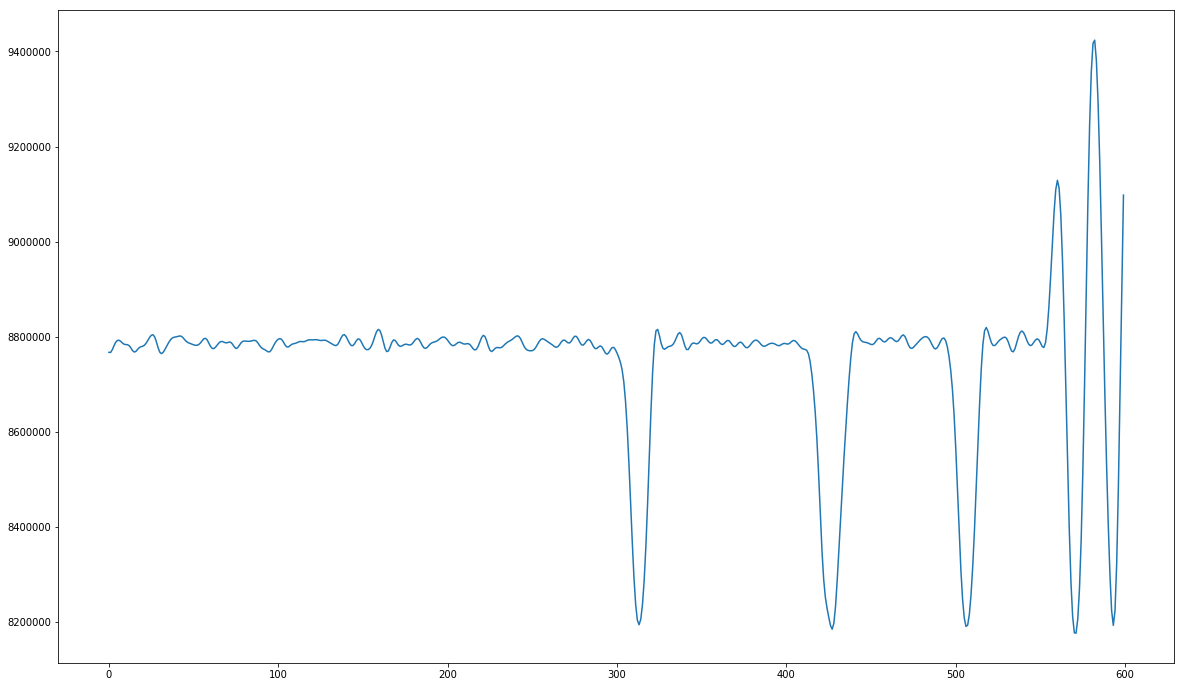

In [258]:
#plt.plot(output_syncf[35000:35100])
plt.plot(output[34500:35100])

In [259]:
np.max(output_syncf)

0.99982597800052164

In [260]:
np.argmax(output_syncf[0:8000])

7679

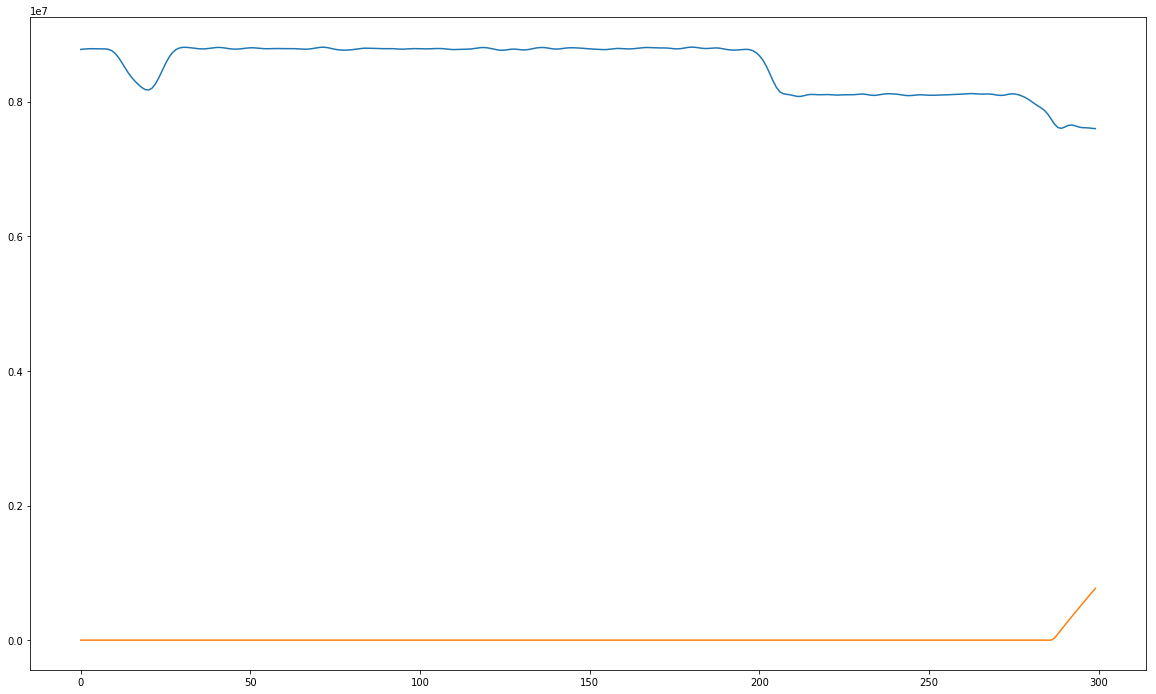

In [261]:
plt.plot(output[4400:4700])
plt.plot(output_syncf[4400:4700] * 9000000)

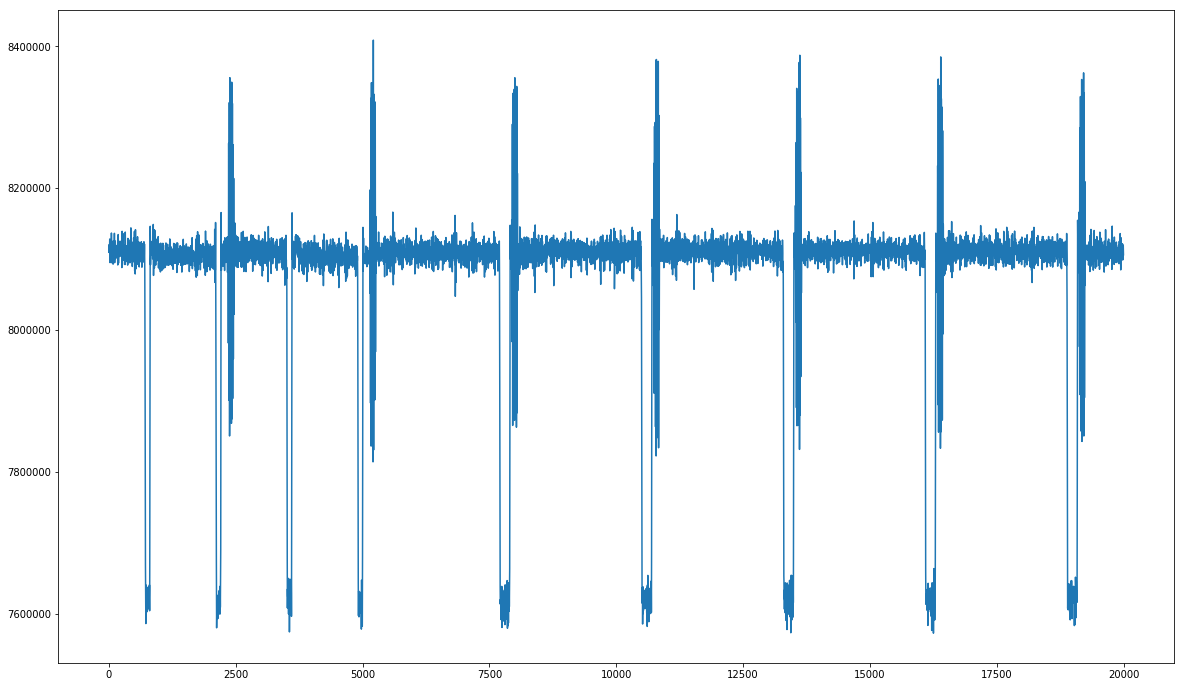

In [262]:
plt.plot(output1[190000:210000])

In [263]:
plt.plot(dsync2a[47340:47370])

NameError: name 'dsync2a' is not defined

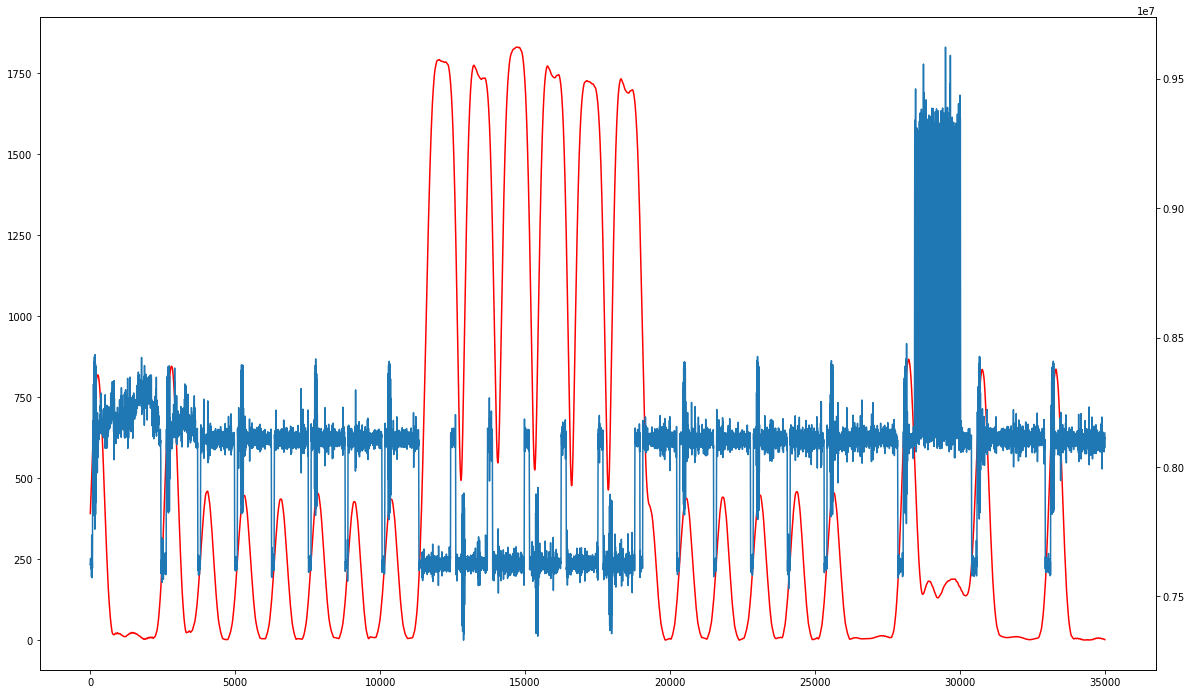

In [620]:
# Plot in different subplots
#fig, (ax1, ax2) = plt.subplots(1, 2)
fig = plt.figure()
ax1 = plt.subplot()
ax2 = plt.twinx()
ax1.plot(dsync2a[35000+256:70000+256], color='red')
ax2.plot(output[35000:70000])


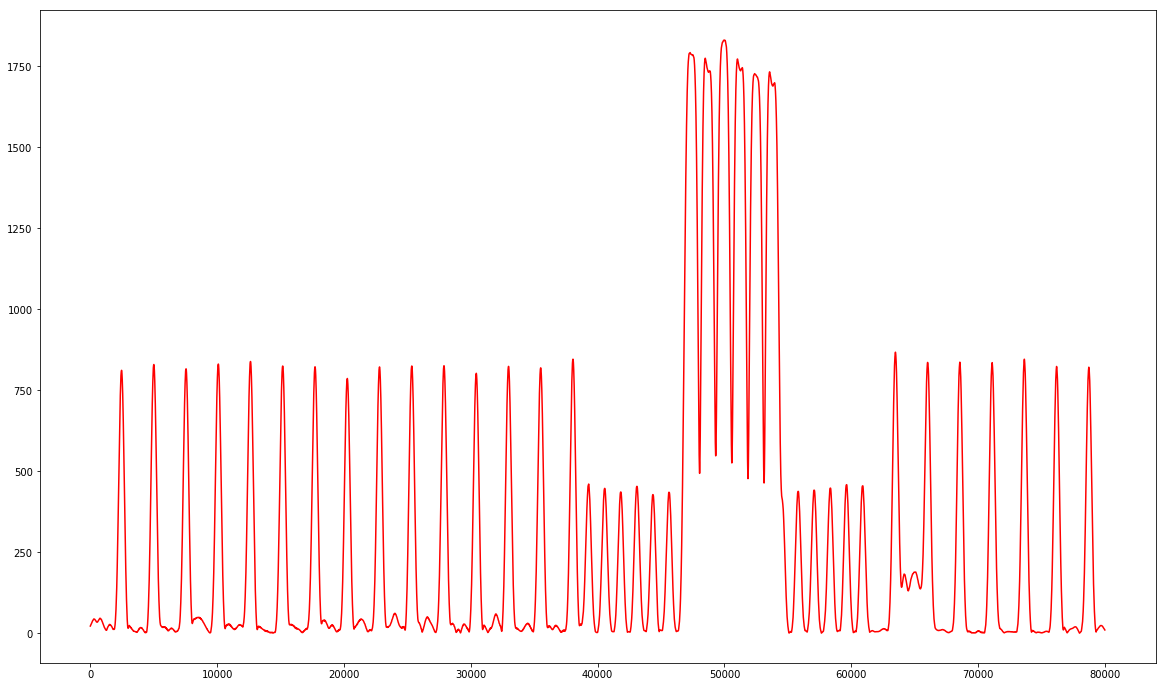

In [558]:
plt.plot(dsync2a[:80000], color='red')


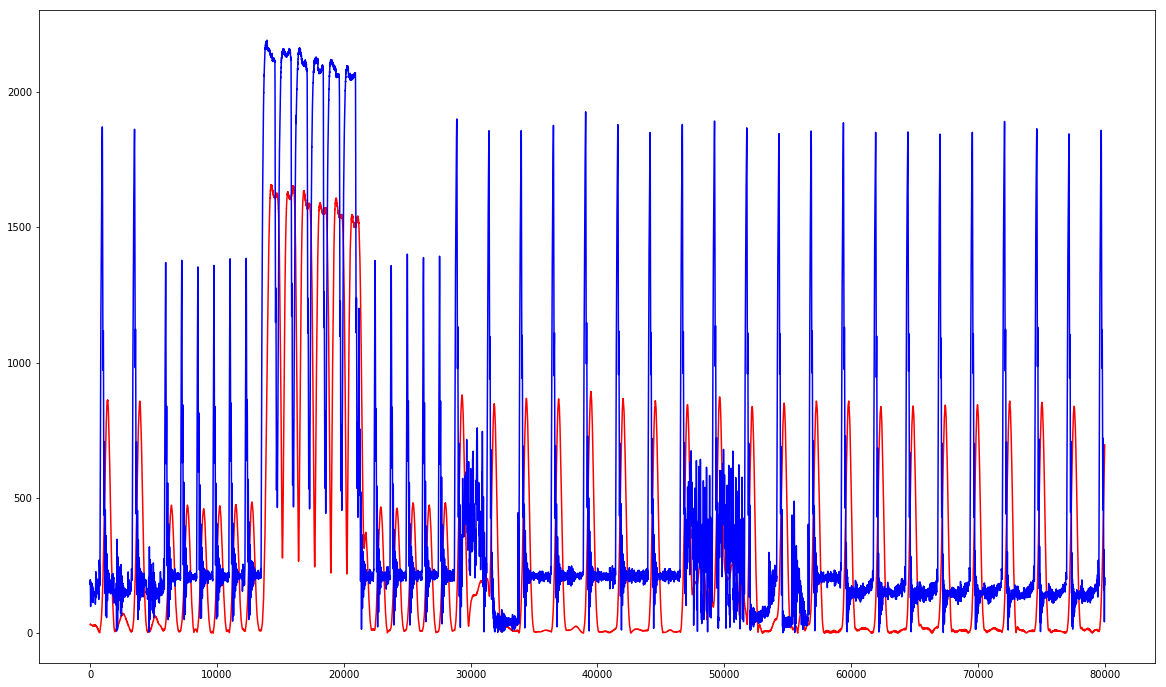

In [527]:
plt.plot(dsync2[700000:780000], color='red')
plt.plot(dsync[700000:780000], color='blue')

In [536]:
dsync2a = dsync2[0:50000]

In [546]:
np.where((dsync2a[:-1] > dsync2a[1:])[:-1] & (dsync2a[1:] > dsync2a[:-1])[1:])

(array([   22,    30,    37, ..., 49992, 49995, 49997]),)

In [553]:
np.argmax(dsync2[0:500000]), np.max(dsync2[0:500000])

(49960, 1831.9653415575606)

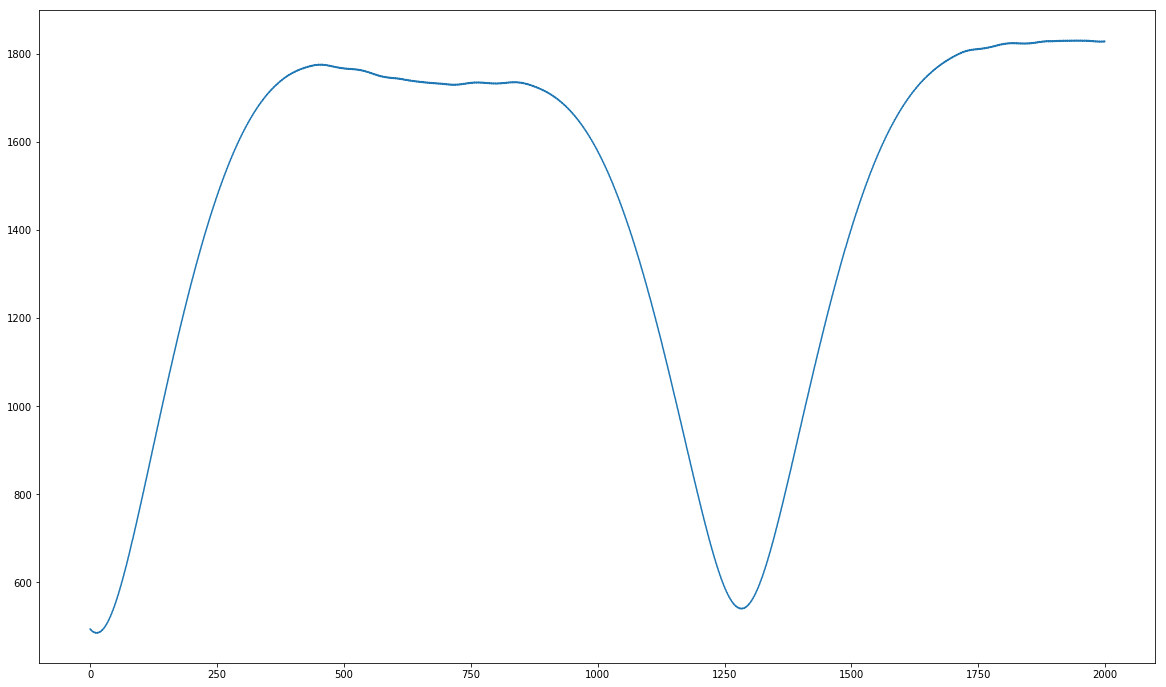

In [554]:
plt.plot(dsync2[48000:50000])

In [547]:
dsync2a[21:31]

array([ 28.2730465 ,  28.22621713,  28.16229576,  28.2034762 ,
        28.2339765 ,  28.1990089 ,  28.13172455,  27.93744449,
        27.74398476,  27.59240033])

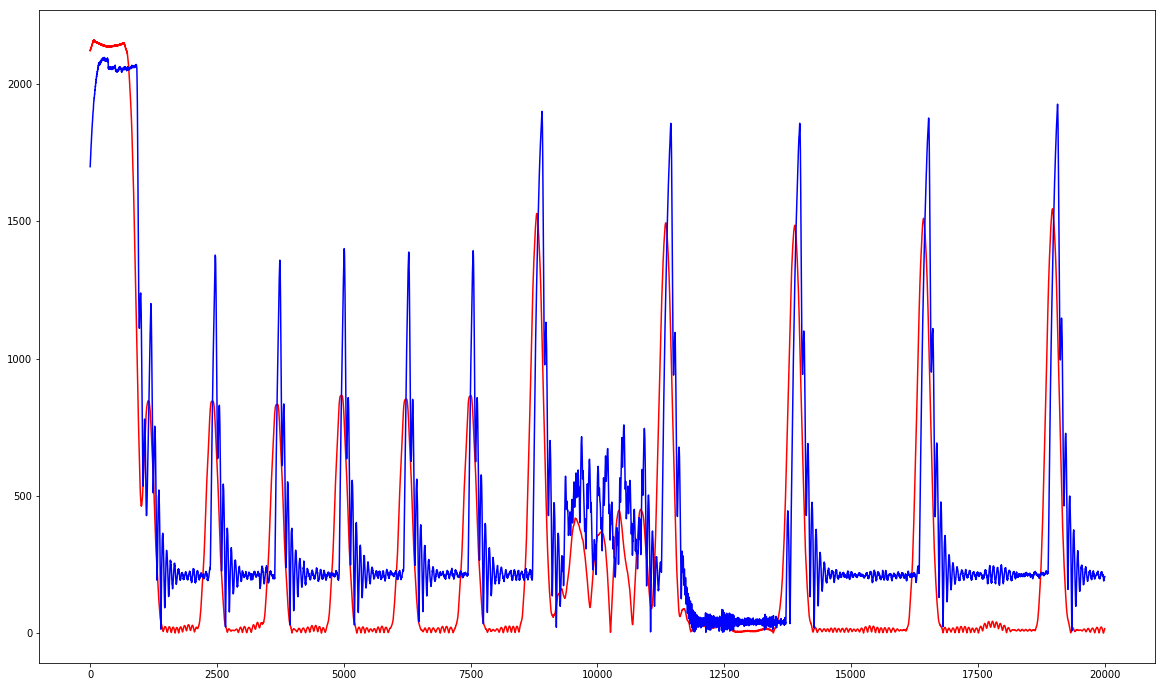

In [520]:
plt.plot(dsync2[720000+256:740000+256], color='red')
plt.plot(dsync[720000:740000], color='blue')

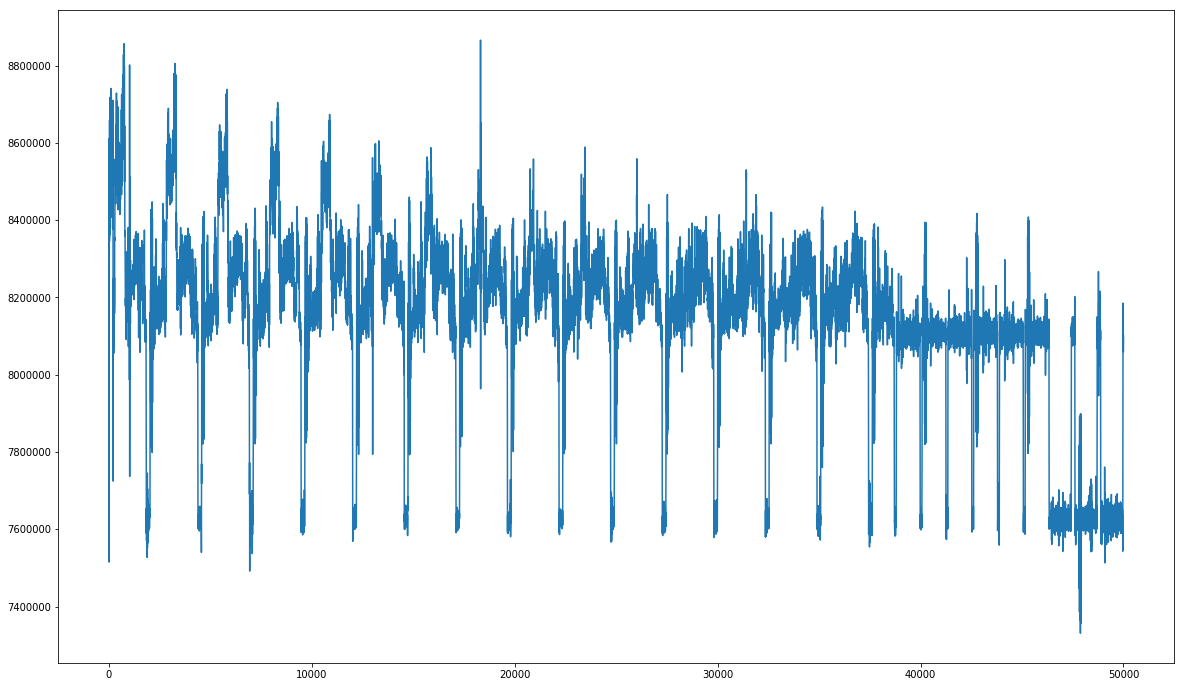

In [498]:
plt.plot(output[0:50000])

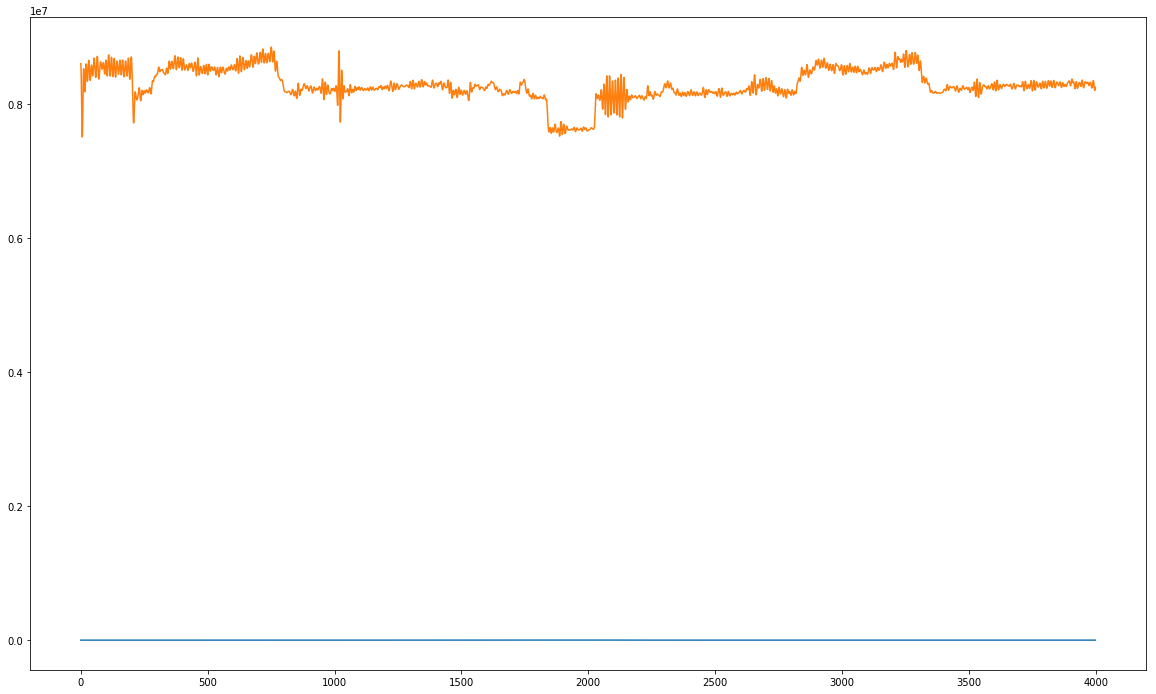

In [486]:
plt.plot(dsync[0+0:4000+0])
plt.plot(output[0:4000])

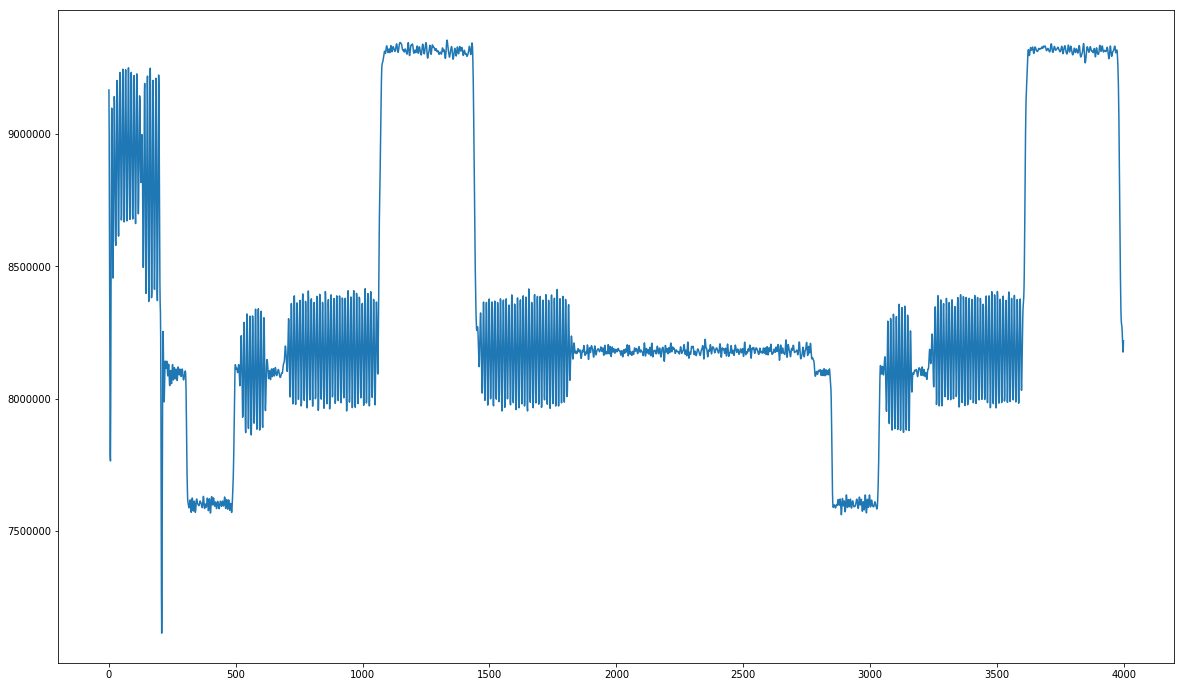

In [471]:
plt.plot(output[0:4000])

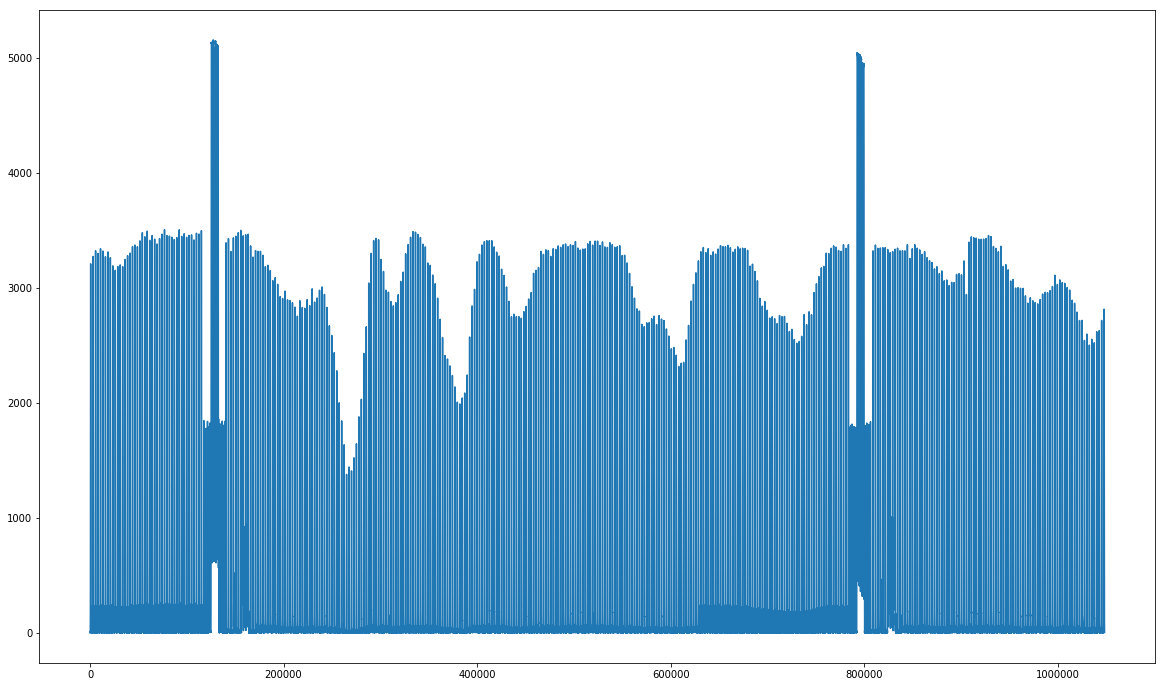

In [469]:
plt.plot(dsync2)

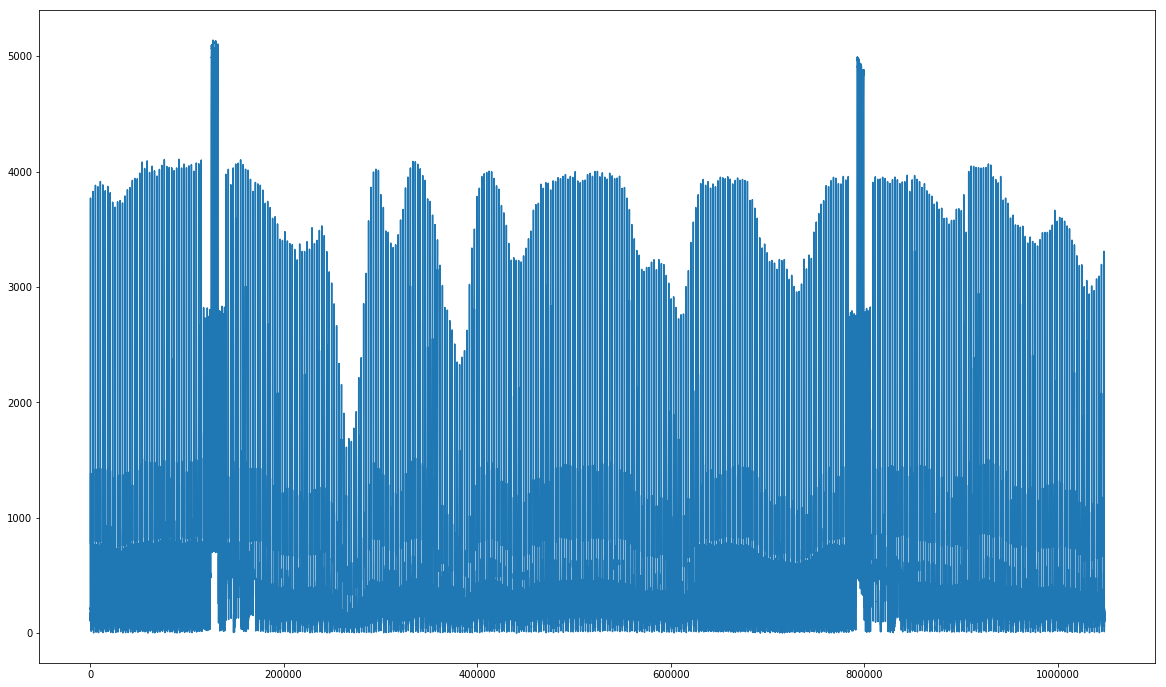

In [442]:
plt.plot(dsync)

In [423]:
dsync.imag

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

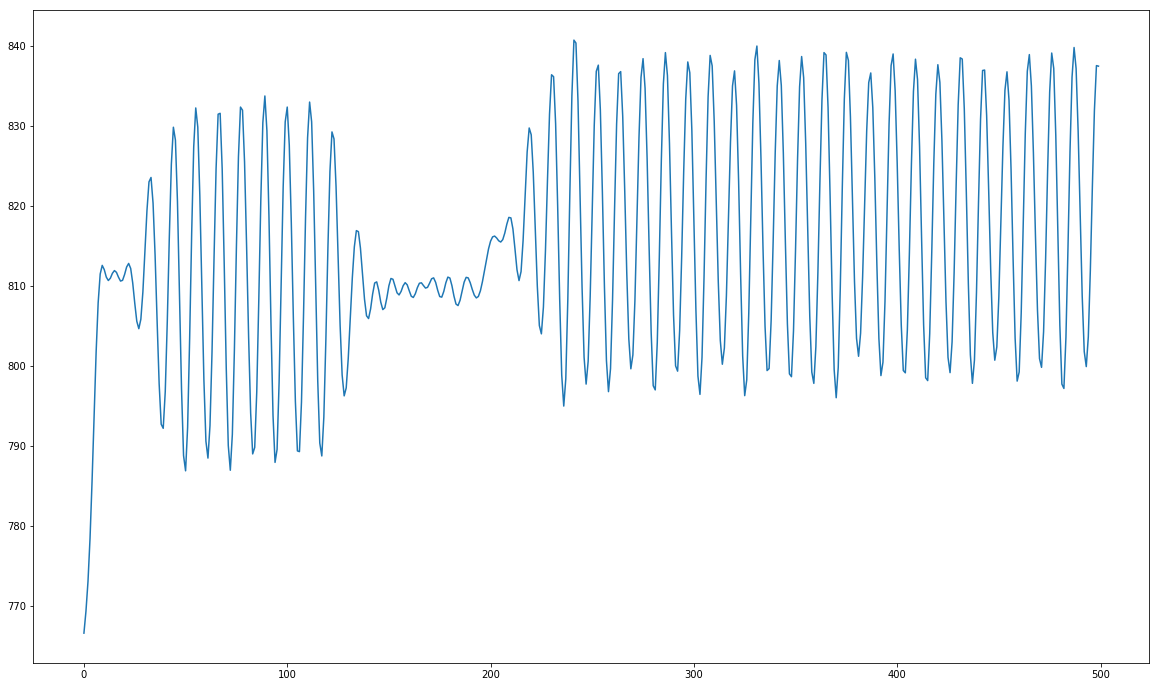

In [430]:
#plt.plot(d0[10000:13000])


idx = 5000 + dsync[5000:20000].argmax()
plt.plot(output[idx:idx+500] / 10**4)
#plt.plot(dsync[idx-100:idx+500])

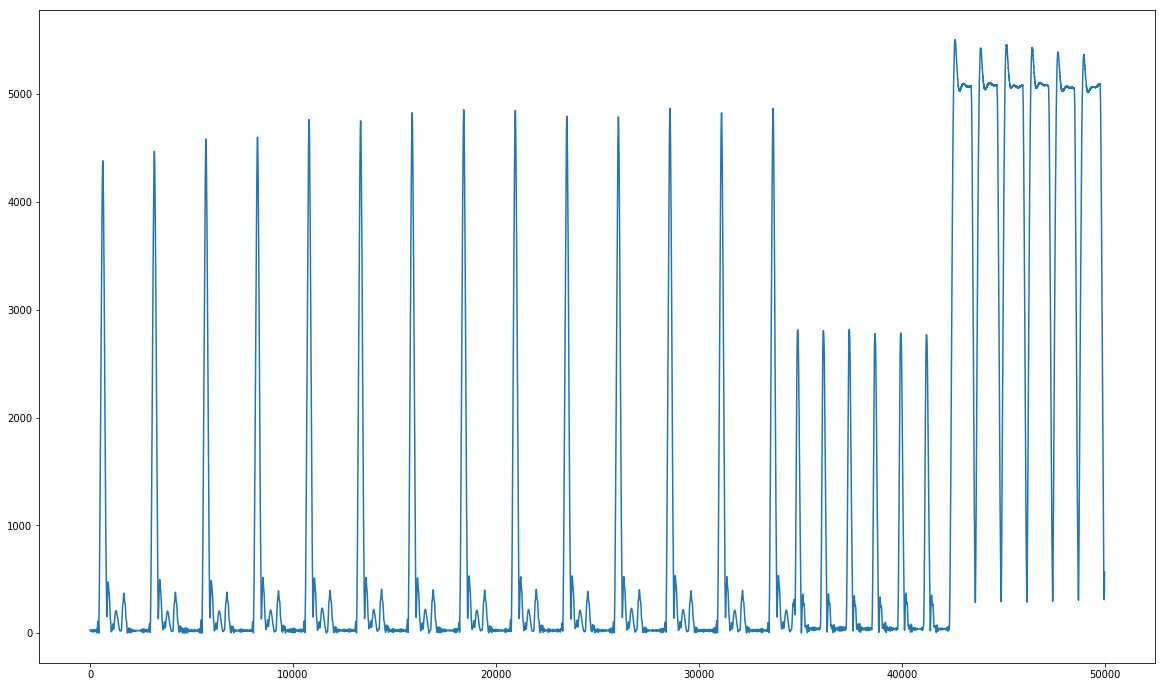

In [163]:
plt.plot(sqsum(dsync[750000:800000])5

In [358]:
freq_half = paramsc['freq'] / 2
cburst_filt = filtfft(sps.butter(1, [(paramsc['fsc_mhz'] - .5)/freq_half, (paramsc['fsc_mhz'] + .5)/freq_half], btype='bandpass'))

cburst_filta = sps.firwin(129, [(paramsc['fsc_mhz'] - .05)/freq_half, (paramsc['fsc_mhz'] + .05)/freq_half], pass_zero=False)
cburst_filta = sps.firwin(21, 2.5/freq_half, pass_zero=False)
cburst_filt = filtfft((cburst_filta, [1.0]))

cburst = np.fft.ifft(demod_fft * cburst_filt)

>-10db crossing at  2.32111150568
>-3db crossing at  2.43297230114
<-3db crossing at  2.71262428977


/home/cpage/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


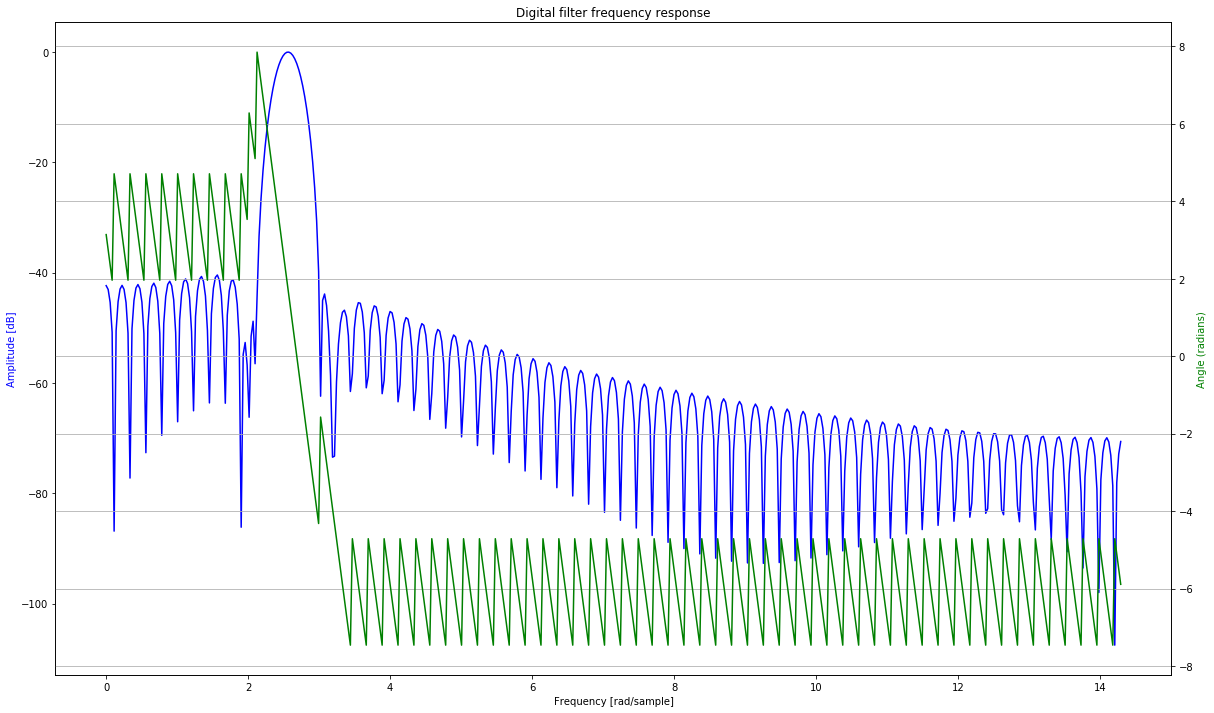

In [488]:
#warnings.warn(message, mplDeprecation, stacklevel=1)
doplot(cburst_filta, [1.0])

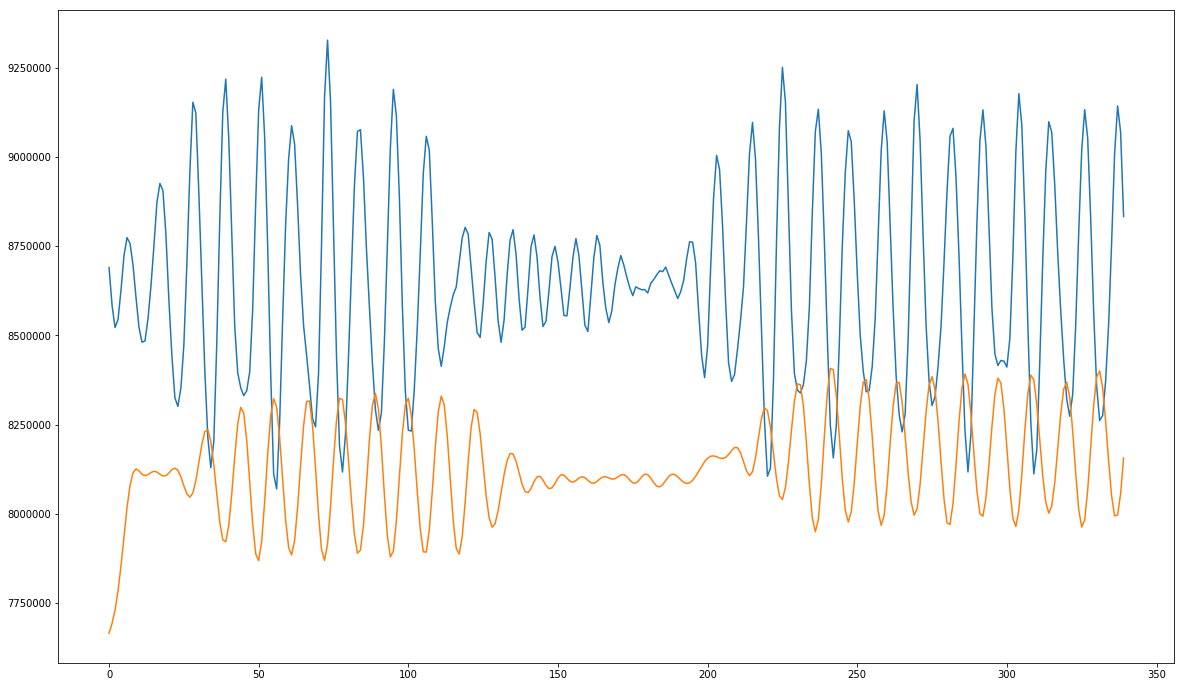

In [360]:
plt.plot((cburst[10660+20:11000+20].real) + 8100000)
plt.plot(output[10660:11000])

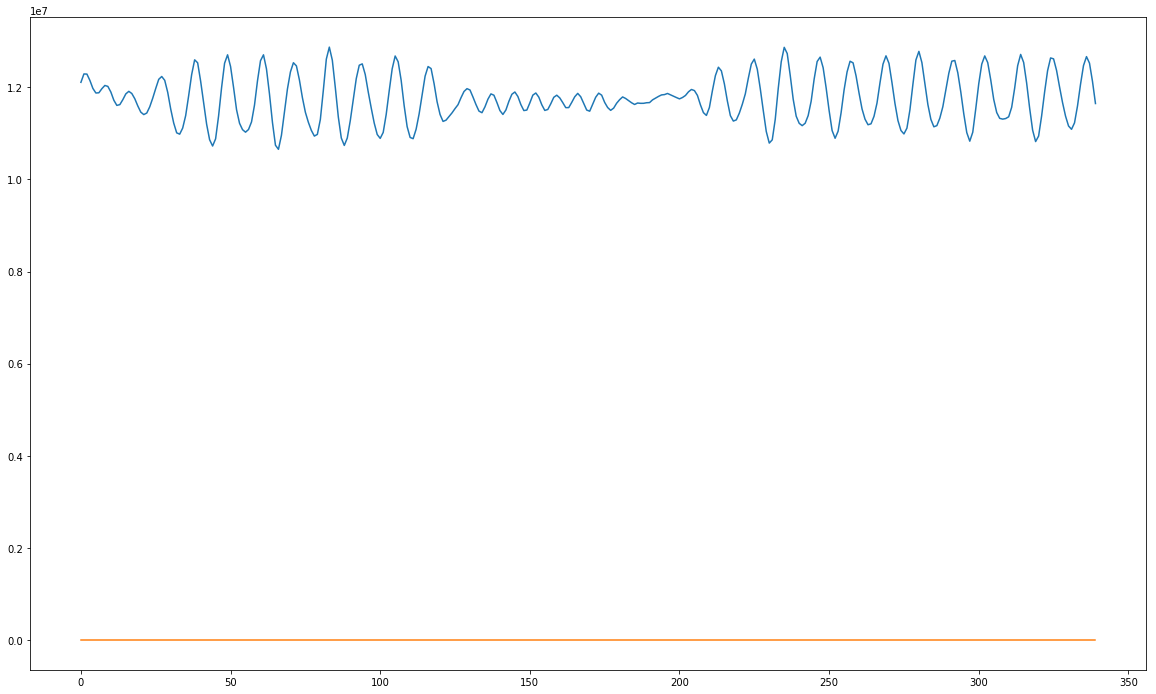

In [262]:
plt.plot(cburst[10660:11000].real)
plt.plot(cburst[10660:11000].imag)g

In [208]:
np.argmax(cburst[10660:11000])

94

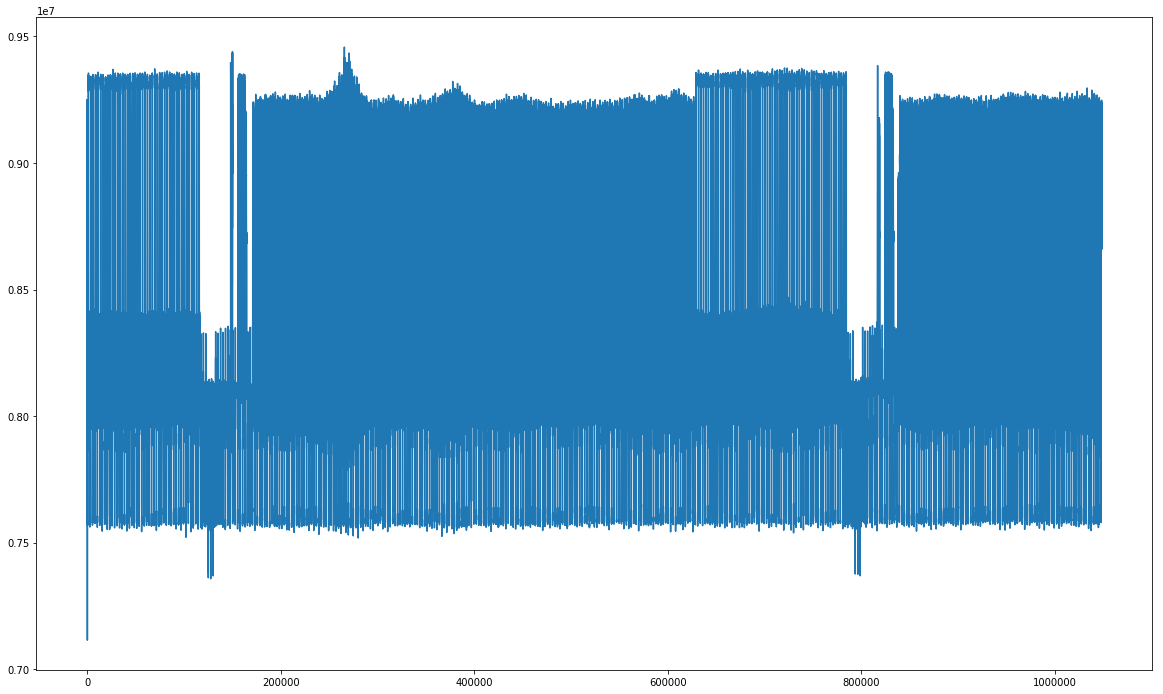

In [148]:
plt.plot(output)

In [ ]:
)